In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import os.path
import skimage
import skimage.segmentation
import sklearn.preprocessing
import sklearn.model_selection
import math
import shutil
import pathlib
import glob
import shutil
import uuid
import random
import platform
import torch
import torchvision
import numpy as np
import scipy as sp
import scipy.io
import scipy.signal
import pandas as pd
import networkx
import wfdb
import fleetfmt
import json
import tqdm
import dill
import pickle
import time
import matplotlib.pyplot as plt

import scipy.stats

import src.data
import src.reader

import sak
import sak.signal.wavelet
import sak.data
import sak.data.augmentation
import sak.visualization
import sak.visualization.signal
import sak.torch
import sak.torch.nn
import sak.torch.nn as nn
import sak.torch.train
import sak.torch.data
import sak.data.preprocessing
import sak.torch.models
import sak.torch.models.lego
import sak.torch.models.variational
import sak.torch.models.classification

from sak.signal import StandardHeader

def smooth(x: np.ndarray, window_size: int, conv_mode: str = 'same'):
    x = np.pad(np.copy(x),(window_size,window_size),'edge')
    window = np.hamming(window_size)/(window_size//2)
    x = np.convolve(x, window, mode=conv_mode)
    x = x[window_size:-window_size]
    return x

# From train_multi.py

In [3]:
bool_hpc    = False
model_name  = "TestSemiSupervisedLearning"
config_file = './configurations/WNet6Levels.json'
input_files = './pickle/'

##### 1. Load configuration file #####
with open(config_file, "r") as f:
    execution = json.load(f)

execution["root_directory"] = os.path.expanduser(execution["root_directory"])
execution["save_directory"] = os.path.expanduser(execution["save_directory"])

# NO ITERATOR FOR HPC, WASTE OF MEMORY
if bool_hpc:
    execution["iterator"] = "none"

##### 2. Load synthetic dataset #####
# 2.1. Load individual segments
P = sak.pickleload(os.path.join(input_files,"Psignal_new.pkl"))
PQ = sak.pickleload(os.path.join(input_files,"PQsignal_new.pkl"))
QRS = sak.pickleload(os.path.join(input_files,"QRSsignal_new.pkl"))
ST = sak.pickleload(os.path.join(input_files,"STsignal_new.pkl"))
T = sak.pickleload(os.path.join(input_files,"Tsignal_new.pkl"))
TP = sak.pickleload(os.path.join(input_files,"TPsignal_new.pkl"))

Pamplitudes = sak.pickleload(os.path.join(input_files,"Pamplitudes_new.pkl"))
PQamplitudes = sak.pickleload(os.path.join(input_files,"PQamplitudes_new.pkl"))
QRSamplitudes = sak.pickleload(os.path.join(input_files,"QRSamplitudes_new.pkl"))
STamplitudes = sak.pickleload(os.path.join(input_files,"STamplitudes_new.pkl"))
Tamplitudes = sak.pickleload(os.path.join(input_files,"Tamplitudes_new.pkl"))
TPamplitudes = sak.pickleload(os.path.join(input_files,"TPamplitudes_new.pkl"))

# 2.2. Get amplitude distribution
Pdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Pamplitudes.values()))))
PQdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(PQamplitudes.values()))))
QRSdistribution = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.hstack((np.array(list(QRSamplitudes.values())), 2-np.array(list(QRSamplitudes.values()))))))
STdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(STamplitudes.values()))))
Tdistribution   = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(Tamplitudes.values()))))
TPdistribution  = scipy.stats.lognorm(*scipy.stats.lognorm.fit(np.array(list(TPamplitudes.values()))))

# 2.3. Smooth all
window = 5
P   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  P[k],window)),metric=sak.signal.abs_max) for k in   P}
PQ  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( PQ[k],window)),metric=sak.signal.abs_max) for k in  PQ}
QRS = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(QRS[k],window)),metric=sak.signal.abs_max) for k in QRS}
ST  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( ST[k],window)),metric=sak.signal.abs_max) for k in  ST}
T   = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth(  T[k],window)),metric=sak.signal.abs_max) for k in   T}
TP  = {k: sak.data.ball_scaling(sak.signal.on_off_correction(smooth( TP[k],window)),metric=sak.signal.abs_max) for k in  TP}


##### 3. Load QTDB #####
dataset             = pd.read_csv(os.path.join(input_files,'QTDB','Dataset.csv'), index_col=0)
dataset             = dataset.sort_index(axis=1)
labels              = np.asarray(list(dataset)) # In case no data augmentation is applied
description         = dataset.describe()
group               = {k: '_'.join(k.split('_')[:-1]) for k in dataset}
unique_ids          = list(set([k.split('_')[0] for k in dataset]))

# Load validity
validity            = sak.load_data(os.path.join(input_files,'QTDB','validity.csv'))

# Load fiducials
Pon_QTDB            = sak.load_data(os.path.join(input_files,'QTDB','PonNew.csv'))
Poff_QTDB           = sak.load_data(os.path.join(input_files,'QTDB','PoffNew.csv'))
QRSon_QTDB          = sak.load_data(os.path.join(input_files,'QTDB','QRSonNew.csv'))
QRSoff_QTDB         = sak.load_data(os.path.join(input_files,'QTDB','QRSoffNew.csv'))
Ton_QTDB            = sak.load_data(os.path.join(input_files,'QTDB','TonNew.csv'))
Toff_QTDB           = sak.load_data(os.path.join(input_files,'QTDB','ToffNew.csv'))

# Generate masks & signals
signal_QTDB = {}
segmentation_QTDB = {}
for k in tqdm.tqdm(QRSon_QTDB):
    # Check file exists and all that
    if k not in validity:
        print("Issue with file {}, continuing...".format(k))
        continue

    # Store signal
    signal = dataset[k][validity[k][0]:validity[k][1]].values
    signal = sak.signal.on_off_correction(signal)
    amplitude = np.median(sak.signal.moving_lambda(signal,200,sak.signal.abs_max))
    signal = signal/amplitude
    signal_QTDB[k] = signal[None,]

    # Generate boolean mask
    segmentation = np.zeros((3,dataset.shape[0]),dtype=bool)
    if k in Pon_QTDB:
        for on,off in zip(Pon_QTDB[k],Poff_QTDB[k]):
            segmentation[0,on:off] = True
    if k in QRSon_QTDB:
        for on,off in zip(QRSon_QTDB[k],QRSoff_QTDB[k]):
            segmentation[1,on:off] = True
    if k in Ton_QTDB:
        for on,off in zip(Ton_QTDB[k],Toff_QTDB[k]):
            segmentation[2,on:off] = True

    segmentation_QTDB[k] = segmentation[:,validity[k][0]:validity[k][1]]


##### 4. Generate random splits #####
# 4.1. Split into train and test
all_keys_synthetic = {}
for k in list(P) + list(PQ) + list(QRS) + list(ST) + list(T) + list(TP):
    uid = k.split("###")[0].split("_")[0].split("-")[0]
    if uid not in all_keys_synthetic:
        all_keys_synthetic[uid] = [k]
    else:
        all_keys_synthetic[uid].append(k)

all_keys_real = {}
for k in list(signal_QTDB) + list(segmentation_QTDB):
    uid = k.split("###")[0].split("_")[0].split("-")[0]
    if uid not in all_keys_real:
        all_keys_real[uid] = [k]
    else:
        all_keys_real[uid].append(k)

# 4.2. Get database and file
filenames = []
database = []
for k in all_keys_synthetic:
    filenames.append(k)
    if k.startswith("SOO"):
        database.append(0)
    elif k.startswith("sel"):
        database.append(1)
    else:
        database.append(2)
filenames = np.array(filenames)
database = np.array(database)

# Set random seed for the execution and perform train/test splitting
random.seed(execution["seed"])
np.random.seed(execution["seed"])
torch.random.manual_seed(execution["seed"])
splitter = sklearn.model_selection.StratifiedKFold(5).split(filenames,database)
splits = list(splitter)
indices_train = [s[0] for s in splits]
indices_valid = [s[1] for s in splits]

##### 5. Train folds #####
# 5.1. Save model-generating files
target_path = execution["save_directory"] # Store original output path for future usage
original_length = execution["dataset"]["length"]
if not os.path.isdir(os.path.join(target_path,model_name)):
    pathlib.Path(os.path.join(target_path,model_name)).mkdir(parents=True, exist_ok=True)
# shutil.copyfile("./train_multi.py",os.path.join(target_path,model_name,"train_multi.py"))
shutil.copyfile("./src/data.py",os.path.join(target_path,model_name,"data.py"))
shutil.copyfile("./src/metrics.py",os.path.join(target_path,model_name,"metrics.py"))
# shutil.copyfile("./sak/torch/nn/modules/loss.py",os.path.join(target_path,model_name,"loss.py"))
shutil.copyfile(config_file,os.path.join(target_path,model_name,os.path.split(config_file)[1]))

# 5.2. Save folds of valid files
all_folds_test = {"fold_{}".format(i+1): np.array(filenames)[ix_valid] for i,ix_valid in enumerate(indices_valid)}
sak.save_data(all_folds_test,os.path.join(target_path,model_name,"validation_files.csv"))

# 5.3. Iterate over folds
for i,(ix_train,ix_valid) in enumerate(zip(indices_train,indices_valid)):
    print("################# FOLD {} #################".format(i+1))
    # Synthetic keys
    train_keys_synthetic, valid_keys_synthetic = ([],[])
    for k in np.array(filenames)[ix_train]: 
        train_keys_synthetic += all_keys_synthetic[k]
    for k in np.array(filenames)[ix_valid]: 
        valid_keys_synthetic += all_keys_synthetic[k]

    # Real keys
    train_keys_real, valid_keys_real = ([],[])
    for k in np.array(filenames)[ix_train]: 
        if k in all_keys_real: train_keys_real += all_keys_real[k]
    for k in np.array(filenames)[ix_valid]: 
        if k in all_keys_real: valid_keys_real += all_keys_real[k]

    # Avoid repetitions
    train_keys_synthetic = list(set(train_keys_synthetic))
    valid_keys_synthetic = list(set(valid_keys_synthetic))
    train_keys_real = list(set(train_keys_real))
    valid_keys_real = list(set(valid_keys_real))

    # ~~~~~~~~~~~~~~~~~~~~ Refine synthetic set ~~~~~~~~~~~~~~~~~~~~
    # Divide train/valid segments
    Ptrain   = {k:   P[k] for k in   P if k in train_keys_synthetic}
    PQtrain  = {k:  PQ[k] for k in  PQ if k in train_keys_synthetic}
    QRStrain = {k: QRS[k] for k in QRS if k in train_keys_synthetic}
    STtrain  = {k:  ST[k] for k in  ST if k in train_keys_synthetic}
    Ttrain   = {k:   T[k] for k in   T if k in train_keys_synthetic}
    TPtrain  = {k:  TP[k] for k in  TP if k in train_keys_synthetic}

    Pvalid   = {k:   P[k] for k in   P if k in valid_keys_synthetic}
    PQvalid  = {k:  PQ[k] for k in  PQ if k in valid_keys_synthetic}
    QRSvalid = {k: QRS[k] for k in QRS if k in valid_keys_synthetic}
    STvalid  = {k:  ST[k] for k in  ST if k in valid_keys_synthetic}
    Tvalid   = {k:   T[k] for k in   T if k in valid_keys_synthetic}
    TPvalid  = {k:  TP[k] for k in  TP if k in valid_keys_synthetic}

    # ~~~~~~~~~~~~~~~~~~~~~~ Refine real set ~~~~~~~~~~~~~~~~~~~~~~~
    signal_QTDB_train       = {k:       signal_QTDB[k] for k in       signal_QTDB if k in train_keys_real}
    signal_QTDB_valid       = {k:       signal_QTDB[k] for k in       signal_QTDB if k in valid_keys_real}
    segmentation_QTDB_train = {k: segmentation_QTDB[k] for k in segmentation_QTDB if k in train_keys_real}
    segmentation_QTDB_valid = {k: segmentation_QTDB[k] for k in segmentation_QTDB if k in valid_keys_real}


    # Prepare folders
    execution["save_directory"] = os.path.join(target_path, model_name, "fold_{}".format(i+1))
    if not os.path.isdir(execution["save_directory"]):
        pathlib.Path(execution["save_directory"]).mkdir(parents=True, exist_ok=True)

    # Define synthetic datasets
    dataset_train_synthetic = src.data.Dataset(Ptrain, QRStrain, Ttrain, PQtrain, STtrain, TPtrain, 
                                               Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                               STdistribution, TPdistribution, **execution["dataset"])
    execution["dataset"]["length"] = execution["dataset"]["length"]//4 # On synthetic data, not so useful to do intensive validation
    dataset_valid_synthetic = src.data.Dataset(Pvalid, QRSvalid, Tvalid, PQvalid, STvalid, TPvalid, 
                                               Pdistribution, QRSdistribution, Tdistribution, PQdistribution, 
                                               STdistribution, TPdistribution, **execution["dataset"])
    execution["dataset"]["length"] = original_length # On synthetic data, not so useful to do intensive validation

    # Define real datasets
    dataset_train_real = src.data.DatasetQTDB(signal_QTDB_train,segmentation_QTDB_train,execution["dataset"]["N"],128)
    dataset_valid_real = src.data.DatasetQTDB(signal_QTDB_valid,segmentation_QTDB_valid,execution["dataset"]["N"],128)

    # Define merging dataset
    dataset_train = sak.torch.data.UniformMultiDataset((dataset_train_synthetic,dataset_train_real),[10,1],[1,10],return_weights=True)
    sampler_train = sak.torch.data.UniformMultiSampler(dataset_train)
    dataset_valid = sak.torch.data.UniformMultiDataset((dataset_valid_synthetic,dataset_valid_real),[10,1],[1,10],return_weights=True)
    sampler_valid = sak.torch.data.UniformMultiSampler(dataset_valid)

    # Create dataloaders
    loader_train = torch.utils.data.DataLoader(dataset_train, sampler=sampler_train, **execution["loader"])
    loader_valid = torch.utils.data.DataLoader(dataset_valid, sampler=sampler_valid, **execution["loader"])

    # Define model
    model = sak.from_dict(execution["model"]).float().cuda()

    # Train model
    state = {
        "epoch"         : 0,
        "device"        : torch.device("cuda" if torch.cuda.is_available() else "cpu"),
        "optimizer"     : sak.class_selector(execution["optimizer"]["class"])(model.parameters(), **execution["optimizer"]["arguments"]),
        "root_dir"      : "./"
    }
    if "scheduler" in execution:
        state["scheduler"] = sak.class_selector(execution["scheduler"]["class"])(state["optimizer"], **execution["scheduler"]["arguments"])
    
    break

100%|██████████| 206/206 [00:00<00:00, 2470.86it/s]


Issue with file sel35_0, continuing...
Issue with file sel35_1, continuing...
################# FOLD 1 #################


In [4]:
def get_batch_ssl(loader_labeled,loader_unlabeled):
    # Set up all stuff
    counter_labeled,counter_unlabeled =                    0,                      0
    length_labeled,length_unlabeled   =  len(loader_labeled),  len(loader_unlabeled)
    iter_labeled,    iter_unlabeled   = iter(loader_labeled), iter(loader_unlabeled)
    maxlen                            =  max(length_labeled,       length_unlabeled)
    
    # Get examples
    for _ in range(maxlen):
        if counter_labeled   == length_labeled:
            iter_labeled   = iter(loader_labeled)
        if counter_unlabeled == length_unlabeled:
            iter_unlabeled = iter(loader_unlabeled)
        counter_labeled   += 1
        counter_unlabeled += 1

        # Return next element in iterator
        yield (next(iter_labeled), next(iter_unlabeled))



In [28]:
class DatasetUnsupervised(torch.utils.data.Dataset):
    '''Unsupervised dataset'''

    def __init__(self, file: str, window: int, N: int = None, dtype='float32', per_db: bool = True):
        '''Initialization'''
        # Store inputs
        self.file              = pathlib.Path(file)
        with self.file.open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
            self.keys          = list(reader.keys())
            self.keymap        = reader._keymap
            self.schema        = reader._schema
        self.window            = window
        self.dtype             = dtype
        self.N                 = N
        self.per_db            = per_db
            
        if self.per_db:
            self.databases         = []
            self.key_per_database  = {}
            for k in self.keys:
                DB = k.split("/")[0]
                if DB not in self.key_per_database:
                    self.databases.append(DB)
                    self.key_per_database[DB] = []
                self.key_per_database[DB].append(k)
            self.__getkey      = self.__get_key_oversampling
            self.databases     = np.random.permutation(self.databases).tolist()
        else:
            self.__getkey      = self.__get_key_all
            
    def __len__(self):
        '''Denotes the number of elements'''
        return self.N
    
    def __get_key_oversampling(self, i):
        db = self.databases[i%len(self.databases)]
        return random.choice(self.key_per_database[db])
    
    def __get_key_all(self, i):
        return random.choice(self.key_per_database[db])
    
    def __getitem__(self, i):
        # Get key
        key = self.__getkey(i)
        
        # Read fragment
        try:
            with self.file.open("rb") as fhandle, fleetfmt.FileReader(fhandle,self.keymap,self.schema) as reader:
                fragment = reader.read(key)
        except pickle.UnpicklingError:
            print(key)
            raise
        
        # Generate onset randomly
        onset = random.randint(0,fragment.size-self.window)
        
        # Return fragment as dict
        return {"x": fragment[onset:onset+self.window].astype(self.dtype)}


In [45]:
class DatasetUnsupervised(torch.utils.data.Dataset):
    '''Unsupervised dataset'''

    def __init__(self, file: str, window: int, N: int = None, dtype='float32', per_db: bool = True):
        '''Initialization'''
        # Store inputs
        self.file              = pathlib.Path(file)
        with self.file.open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
            self.keys          = list(reader.keys())
            self.keymap        = reader._keymap
            self.schema        = reader._schema
        self.window            = window
        self.dtype             = dtype
        self.N                 = N
        self.per_db            = per_db
            
        if self.per_db:
            self.databases         = []
            self.key_per_database  = {}
            for k in self.keys:
                DB = k.split("/")[0]
                if DB not in self.key_per_database:
                    self.databases.append(DB)
                    self.key_per_database[DB] = []
                self.key_per_database[DB].append(k)
            self.__getkey      = self.__get_key_oversampling
            self.databases     = np.random.permutation(self.databases).tolist()
        else:
            self.__getkey      = self.__get_key_all
            
    def __len__(self):
        '''Denotes the number of elements'''
        return self.N
    
    def __get_key_oversampling(self, i):
        db = self.databases[i%len(self.databases)]
        return random.choice(self.key_per_database[db])
    
    def __get_key_all(self, i):
        return random.choice(self.key_per_database[db])
    
    def __getitem__(self, i):
        # Get key
        key = self.__getkey(i)
        
        # Read fragment
        try:
            with self.file.open("rb") as fhandle, fleetfmt.FileReader(fhandle,self.keymap,self.schema) as reader:
                fragment = reader.read(key)
        except pickle.UnpicklingError:
            print(key)
            raise
        
        # Generate onset randomly
        onset = random.randint(0,fragment.size-self.window)
        
        # Return fragment as dict
        return {"x": fragment[onset:onset+self.window].astype(self.dtype)}


In [ ]:
np.random.seed(1234); torch.manual_seed(1234)
dataset_mpl_4 = DatasetUnsupervised("/media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet",2048,N=100000)
tmp = execution["loader"].copy()
tmp["num_workers"] = 4
loader_mpl_4  = torch.utils.data.DataLoader(dataset_mpl_4, **tmp)

In [ ]:
%%timeit
for i,batch in enumerate(loader_mpl_4):
    if i == 10:
        break

In [ ]:
np.random.seed(1234); torch.manual_seed(1234)
dataset_mpl_4 = DatasetUnsupervised("/media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet",2048,N=100000)
tmp = execution["loader"].copy()
tmp["num_workers"] = 8
loader_mpl_4  = torch.utils.data.DataLoader(dataset_mpl_4, **tmp)

In [ ]:
%%timeit
for i,batch in enumerate(loader_mpl_4):
    if i == 10:
        break

In [46]:
np.random.seed(1234); torch.manual_seed(1234)
dataset_mpl_4 = DatasetUnsupervised("/media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet",2048,N=100000)
tmp = execution["loader"].copy()
tmp["num_workers"] = 0
loader_mpl_4  = torch.utils.data.DataLoader(dataset_mpl_4, **tmp)

In [ ]:
%%timeit
for i,batch in enumerate(loader_mpl_4):
    if i == 10:
        break

In [43]:
np.random.seed(1234); torch.manual_seed(1234)
dataset_mpl_4 = DatasetUnsupervised("/media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet",2048,N=100000)
tmp = execution["loader"].copy()
tmp["num_workers"] = 0
loader_mpl_4  = torch.utils.data.DataLoader(dataset_mpl_4, **tmp)

In [44]:
%%timeit
for i,batch in enumerate(loader_mpl_4):
    if i == 10:
        break

536 ms ± 23 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [135]:
!rm -rf /media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED_2/

In [136]:
root = "/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED_2/"
to_check = []
with pathlib.Path("/media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet").open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
    tmp_keys = np.random.permutation(list(reader.keys())).tolist()
    for i,k in enumerate(tqdm.tqdm(tmp_keys)):
        if i < 10000:
            aaa = reader.read(k)
            try:
                db,pt,idx = k.split("/")
                idx = idx.replace("###","_")
            except ValueError:
                to_check.append(k)
                continue
            path = pathlib.Path(os.path.join(root,db,pt,idx+".pkl"))
            path.parent.mkdir(parents=True, exist_ok=True)
            buf = pickle.dumps(aaa,protocol=5)
            # wrap = io.BufferedReader(io.BytesIO(buf))
            with path.open("wb") as f: 
                f.write(buf)
#             with path.open("wb") as whandle, fleetfmt.FileWriter(whandle) as writer:
#                 writer.append(0,aaa)


100%|██████████| 3959209/3959209 [00:23<00:00, 171156.58it/s]


In [138]:
all_files_2 = glob.glob("/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED_2/**/*.pkl",recursive=True)

In [142]:
path_2 = pathlib.Path(all_files[0])
with path_2.open("rb") as f: 
    fff = pickle.loads(f.read())

In [148]:
%%timeit
with open(all_files[0],"rb") as f: 
    fff = pickle.loads(f.read())

79.6 µs ± 723 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [147]:
%%timeit
with path_2.open("rb") as f: 
    fff = pickle.loads(f.read())

82.9 µs ± 373 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [143]:
%%timeit
with path_2.open("rb") as f: 
    pass

40.5 µs ± 502 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [79]:
%%time
all_files = glob.glob("/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED/**/*.pkl",recursive=True)

CPU times: user 10.6 s, sys: 6.14 s, total: 16.8 s
Wall time: 1min 3s


In [115]:
class DatasetUnsupervised(torch.utils.data.Dataset):
    '''Unsupervised dataset'''

    def __init__(self, root: str, window: int, N: int = None, dtype='float32', per_db: bool = True):
        '''Initialization'''
        # Store inputs
        self.root              = root
#         self.all_files         = ['/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED/Brugada/041445/AVF_1.pkl']
#         self.all_files         = [self.all_files[0]]*3959209
        self.all_files         = glob.glob(os.path.join(self.root,"**","*.pkl"),recursive=True)
        self.window            = window
        self.dtype             = dtype
        self.N                 = N
        self.per_db            = per_db
            
        if self.per_db:
            self.databases         = []
            self.key_per_database  = {}
            for file in self.all_files:
                root,idx = os.path.split(file)
                root,pat = os.path.split(root)
                root,db  = os.path.split(root)
                if db not in self.key_per_database:
                    self.databases.append(db)
                    self.key_per_database[db] = []
                self.key_per_database[db].append(file)
            self.__getkey      = self.__get_key_oversampling
            self.databases     = np.random.permutation(self.databases).tolist()
        else:
            self.__getkey      = self.__get_key_all
            
    def __len__(self):
        '''Denotes the number of elements'''
        return self.N
    
    def __get_key_oversampling(self, i):
        db = self.databases[i%len(self.databases)]
        return random.choice(self.key_per_database[db])
    
    def __get_key_all(self, i):
        return random.choice(self.key_per_database[db])
    
    def __getitem__(self, i):
        # Get key
        key = self.__getkey(i)
        
        # Read fragment
        with open(key,"rb"):
            fragment = pickle.load(key,protocol=5)
        
        # Generate onset randomly
        onset = random.randint(0,fragment.size-self.window)
        
        # Return fragment as dict
        return {"x": fragment[None,onset:onset+self.window].astype(self.dtype)}



In [116]:
dataset_mpl_4 = DatasetUnsupervised("/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED/",2048,N=100000)
tmp = execution["loader"].copy()
tmp["num_workers"] = 0
loader_mpl_4  = torch.utils.data.DataLoader(dataset_mpl_4, **tmp)

In [90]:
dataset_mpl_2 = DatasetUnsupervised("/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED/",2048,N=100000)
tmp = execution["loader"].copy()
tmp["num_workers"] = 4
loader_mpl_2  = torch.utils.data.DataLoader(dataset_mpl_2, **tmp)

In [91]:
len(dataset_mpl_2.all_files)

3959209

In [117]:
%%timeit
for batch in loader_mpl_4:
    break

TypeError: 'protocol' is an invalid keyword argument for load()

In [109]:
%%timeit
for batch in loader_mpl:
    break

952 ms ± 101 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [102]:
# %%timeit
# for batch in loader_mpl_2:
#     break

287 ms ± 4.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [108]:
%%timeit
for batch in loader_mpl_3:
    break

111 ms ± 10.1 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [96]:
bbb = batch["x"]

In [76]:
batch["x"].shape

torch.Size([64, 1, 2048])

In [77]:
%timeit dataset_mpl[0]

73.6 µs ± 845 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [47]:
!du -s "/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED/"

1233332	/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED/


In [42]:
pickle.dump(aaa,path.as_posix())

TypeError: file must have a 'write' attribute

In [35]:
path.parent

PosixPath('/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED/MUSE/20180111_155115_19000')

In [27]:
path.mkdir(parents=True, exist_ok=True)

In [32]:
!rm -rf /media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED/MUSE/20180111_155115_19000/I_0.pkl/

In [19]:
db,pt,idx

('MUSE', '20180111_155115_19000', 'I_0')

In [14]:
(a,b) = k.split("/")

ValueError: too many values to unpack (expected 2)

In [12]:
os.path.join("/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED",k)

'/media/guille/DADES/DADES/ECG/ALL_UNSUPERVISED/MUSE/20180111_155115_19000/I###0'

In [74]:
class DatasetUnsupervised(torch.utils.data.IterableDataset):
    '''Unsupervised dataset'''

    def __init__(self, file: str, window: int, N: int = None, dtype='float32', per_db: bool = True):
        '''Initialization'''
        # Store inputs
        self.file              = pathlib.Path(file)
        self.window            = window
        self.dtype             = dtype
        self.N                 = N
        self.per_db            = per_db
        
        # Read keys
        with self.file.open("rb") as fhandle, fleetfmt.FileReader(fhandle) as reader:
            self.keys          = list(reader.keys())
            
        # Organize keys logically depending on parameters
        if self.per_db:
            self.databases         = []
            self.key_per_database  = {}
            for k in self.keys:
                DB = k.split("/")[0]
                if DB not in self.key_per_database:
                    self.databases.append(DB)
                    self.key_per_database[DB] = []
                self.key_per_database[DB].append(k)
            self.databases     = np.random.permutation(self.databases).tolist()
            
    def __iter__(self):
        print("!")
        # Establish total number of samples
        total_samples = len(self)
        
        # Get keys to read
        all_keys = []
        if self.per_db:
            for db in self.databases:
                all_keys += random.choices(self.key_per_database[db], k=math.ceil(self.N/len(self.databases)))
        else:
            all_keys += random.choices(self.keys, k=self.N)
        all_keys = np.random.permutation(all_keys).tolist()
        
        # Read chunk
        with self.file.open("rb") as fhandle, fleetfmt.FileReader(fhandle) as reader:
            self.chunk = [{"x": reader.read(key)} for key in all_keys]
        
        return iter(self.chunk)
            
    def __len__(self):
        '''Denotes the number of batches per epoch'''
        return self.N


In [75]:
dataset_mpl = DatasetUnsupervised("/media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet",2048,N=100000)

In [76]:
dataset_mpl = DatasetUnsupervised("/media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet",2048,N=100000)
tmp = execution["loader"].copy()
tmp["num_workers"] = 4
loader_mpl  = torch.utils.data.DataLoader(dataset_mpl, **tmp)

In [77]:
for batch in loader_mpl:
    break

!!

In [ ]:
dataset_mpl

In [43]:
errors = [
    "MUSE/20180118_173529_22000/II###0",
    "MUSE/20180114_072013_53000/V4###0",
    "MUSE/20180116_131500_57000/V4###0",
    "MUSE/20180112_130501_66000/AVR###0",
    "MUSE/20180113_124114_43000/V1###0",
    "MUSE/20180114_121205_33000/V2###0",
    "MUSE/20180111_165556_14000/III###0",
    "MUSE/20180115_123003_08000/AVF###0",
    "MUSE/20180712_151754_41000/V2###0",
]
with pathlib.Path("/media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet").open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
    for e in errors:
        aaa = reader.read(e)


In [44]:
for e in errors:
    aaa = dataset_mpl.read(e)


In [45]:
for _ in range(len(dataset_mpl)):
    dataset_mpl[_]

0
MUSE/20180116_125025_40000/V1###0
1
MUSE/20180118_131925_69000/I###0
2
MUSE/20180712_153626_86000/V3###0
3
MUSE/20180113_175412_09000/V6###0
4
MUSE/20180712_151003_80000/AVF###0
5
MUSE/20180210_121644_57000/V5###0
6
MUSE/20180210_132809_23000/V1###0
7
MUSE/20180112_131856_15000/II###0
8
MUSE/20180210_124223_06000/V5###0
9
MUSE/20180115_125540_17000/V6###0
10
MUSE/20180114_170745_84000/I###0
11
MUSE/20180712_151041_44000/AVF###0
12
MUSE/20180112_071945_54000/AVL###0
13
MUSE/20180115_134655_12000/V6###0
14
MUSE/20180210_120933_76000/V4###0
15
MUSE/20180112_134830_84000/V2###0
16
MUSE/20180114_172051_25000/III###0
17
MUSE/20180712_154400_64000/V6###0
18
MUSE/20180111_170102_10000/AVL###0
19
MUSE/20180116_124640_27000/V1###0
20
MUSE/20180113_071734_35000/V4###0
21
MUSE/20180116_130437_70000/V2###0
22
MUSE/20180116_124144_65000/V5###0
23
MUSE/20180209_130001_55000/V5###0
24
MUSE/20180119_170706_66000/V4###0
25
MUSE/20180112_170105_02000/AVL###0
26
MUSE/20180114_135158_19000/II###0
27
MUSE

1178
MUSE/20180115_122750_06000/AVF###0
1179
MUSE/20180113_180702_73000/V6###0
1180
MUSE/20180209_121413_59000/V3###0
1181
MUSE/20180113_122214_80000/V4###0
1182
MUSE/20180118_170958_32000/V1###0
1183
MUSE/20180112_130337_67000/AVR###0
1184
MUSE/20180209_173640_20000/II###0
1185
MUSE/20180113_073230_90000/AVR###0
1186
MUSE/20180115_132228_19000/I###0
1187
MUSE/20180209_174935_26000/V5###0
1188
MUSE/20180113_184331_50000/V6###0
1189
MUSE/20180210_125935_91000/AVF###0
1190
MUSE/20180113_115609_72000/AVL###0
1191
MUSE/20180118_171626_16000/V4###0
1192
MUSE/20180116_181615_23000/AVR###0
1193
MUSE/20180118_125051_70000/V6###0
1194
MUSE/20180112_074822_57000/V3###0
1195
MUSE/20180116_130723_84000/II###0
1196
MUSE/20180114_171508_02000/I###0
1197
MUSE/20180112_072340_24000/AVR###0
1198
MUSE/20180113_171303_45000/V3###0
1199
MUSE/20180118_125825_82000/V5###0
1200
MUSE/20180118_133741_56000/V3###0
1201
MUSE/20180114_133804_82000/I###0
1202
MUSE/20180209_123644_62000/V3###0
1203
MUSE/20180210_13

2494
MUSE/20180119_174632_98000/V6###0
2495
MUSE/20180113_132253_71000/V6###0
2496
MUSE/20180712_150824_56000/V1###0
2497
MUSE/20180114_131842_40000/V6###0
2498
MUSE/20180115_125440_08000/V5###0
2499
MUSE/20180112_170229_23000/V1###0
2500
MUSE/20180116_132415_97000/II###0
2501
MUSE/20180209_132048_53000/AVL###0
2502
MUSE/20180210_123824_59000/V4###0
2503
MUSE/20180210_131015_37000/AVL###0
2504
MUSE/20180209_175405_70000/II###0
2505
MUSE/20180111_160435_36000/AVL###0
2506
MUSE/20180712_160026_53000/V3###0
2507
MUSE/20180210_115249_25000/I###0
2508
MUSE/20180209_114832_65000/V6###0
2509
MUSE/20180113_183334_33000/V4###0
2510
MUSE/20180118_174554_10000/II###0
2511
MUSE/20180114_073907_64000/II###0
2512
MUSE/20180120_120639_63000/AVL###0
2513
MUSE/20180113_125234_77000/III###0
2514
MUSE/20180118_132455_45000/V5###0
2515
MUSE/20180112_170307_12000/I###0
2516
MUSE/20180113_180653_22000/AVR###0
2517
MUSE/20180112_120552_80000/V1###0
2518
MUSE/20180116_123306_96000/III###0
2519
MUSE/20180209_1

3835
MUSE/20180210_133032_52000/III###0
3836
MUSE/20180712_151246_23000/II###0
3837
MUSE/20180115_131711_99000/V4###0
3838
MUSE/20180112_165703_94000/V3###0
3839
MUSE/20180210_132828_96000/AVL###0
3840
MUSE/20180112_132818_74000/V1###0
3841
MUSE/20181222_204236_34000/AVR###0
3842
MUSE/20180209_124545_99000/II###0
3843
MUSE/20180118_171502_53000/V5###0
3844
MUSE/20180712_154607_06000/V5###0
3845
MUSE/20180114_071101_50000/V3###0
3846
MUSE/20180118_133036_62000/V1###0
3847
MUSE/20180112_073556_78000/V6###0
3848
MUSE/20180114_073825_80000/III###0
3849
MUSE/20180114_072747_37000/III###0
3850
MUSE/20180210_131325_57000/V6###0
3851
MUSE/20180712_151426_58000/V2###0
3852
MUSE/20180118_181541_69000/V6###0
3853
MUSE/20180113_135123_24000/AVF###0
3854
MUSE/20180113_132001_99000/AVL###0
3855
MUSE/20180114_071254_96000/AVR###0
3856
MUSE/20180114_073555_87000/AVF###0
3857
MUSE/20180115_125732_43000/V3###0
3858
MUSE/20180113_075504_29000/V2###0
3859
MUSE/20180114_123044_04000/V5###0
3860
MUSE/201807

5231
MUSE/20180209_125900_09000/AVL###0
5232
MUSE/20180118_121825_58000/AVR###0
5233
MUSE/20180118_122419_94000/I###0
5234
MUSE/20180111_163135_68000/V4###0
5235
MUSE/20180113_120351_15000/V5###0
5236
MUSE/20180210_130755_72000/V1###0
5237
MUSE/20180112_120652_00000/V4###0
5238
MUSE/20180114_080256_57000/AVL###0
5239
MUSE/20180116_120811_61000/V1###0
5240
MUSE/20180113_121709_00000/AVR###0
5241
MUSE/20180115_134456_00000/AVL###0
5242
MUSE/20180114_070144_47000/V2###0
5243
MUSE/20180116_174846_79000/III###0
5244
MUSE/20180113_180017_13000/AVL###0
5245
MUSE/20180120_121012_82000/V3###0
5246
MUSE/20180118_123724_54000/V4###0
5247
MUSE/20180118_125119_72000/I###0
5248
MUSE/20180114_130605_78000/AVR###0
5249
MUSE/20180115_125056_37000/V3###0
5250
MUSE/20180113_135114_12000/III###0
5251
MUSE/20180113_182555_79000/I###0
5252
MUSE/20180114_121030_51000/V5###0
5253
MUSE/20180111_160357_99000/V1###0
5254
MUSE/20180209_122727_87000/II###0
5255
MUSE/20180112_134032_08000/V2###0
5256
MUSE/20180712_

MUSE/20180114_125841_26000/II###0
6506
MUSE/20180118_181934_79000/V2###0
6507
MUSE/20180115_132852_48000/V5###0
6508
MUSE/20180112_123348_05000/AVF###0
6509
MUSE/20180116_122124_78000/AVR###0
6510
MUSE/20180114_072450_54000/AVF###0
6511
MUSE/20180114_073300_01000/AVR###0
6512
MUSE/20180112_124224_77000/AVR###0
6513
MUSE/20180712_160238_11000/I###0
6514
MUSE/20180209_122759_90000/AVL###0
6515
MUSE/20180116_124726_96000/AVF###0
6516
MUSE/20180118_181406_77000/II###0
6517
MUSE/20180712_152345_78000/V4###0
6518
MUSE/20180120_121353_76000/V4###0
6519
MUSE/20180113_131227_79000/V6###0
6520
MUSE/20180209_121847_03000/V3###0
6521
MUSE/20180113_122344_54000/V2###0
6522
MUSE/20180116_121427_55000/V6###0
6523
MUSE/20180120_122440_80000/V1###0
6524
MUSE/20180116_132754_12000/II###0
6525
MUSE/20180114_075050_69000/V5###0
6526
MUSE/20180112_122652_84000/I###0
6527
MUSE/20180712_151657_42000/I###0
6528
MUSE/20180116_171344_17000/AVR###0
6529
MUSE/20180116_121359_30000/V6###0
6530
MUSE/20180114_130004

7966
MUSE/20180120_122752_98000/V3###0
7967
MUSE/20180712_151445_67000/V2###0
7968
MUSE/20180112_132034_75000/V5###0
7969
MUSE/20180119_170132_35000/AVF###0
7970
MUSE/20180115_120611_50000/V5###0
7971
MUSE/20180111_170102_10000/V6###0
7972
MUSE/20180114_131753_49000/V3###0
7973
MUSE/20180113_135418_42000/AVL###0
7974
MUSE/20180120_122250_12000/AVR###0
7975
MUSE/20180114_115336_84000/AVF###0
7976
MUSE/20180112_140823_81000/III###0
7977
MUSE/20180210_132058_67000/I###0
7978
MUSE/20180115_123107_45000/V2###0
7979
MUSE/20180113_183412_36000/V4###0
7980
MUSE/20180209_124032_50000/V4###0
7981
MUSE/20180113_130723_84000/III###0
7982
MUSE/20180114_074754_31000/AVL###0
7983
MUSE/20180210_125844_17000/II###0
7984
MUSE/20180210_131220_37000/I###0
7985
MUSE/20180112_132859_17000/AVL###0
7986
MUSE/20180115_124800_42000/II###0
7987
MUSE/20180209_114343_23000/V3###0
7988
MUSE/20180119_171748_11000/V2###0
7989
MUSE/20180114_073858_47000/V6###0
7990
MUSE/20180115_135010_56000/V1###0
7991
MUSE/20180115_

9441
MUSE/20180113_080817_35000/AVL###0
9442
MUSE/20180210_122855_98000/II###0
9443
MUSE/20180209_125040_34000/AVL###0
9444
MUSE/20180119_174533_57000/AVR###0
9445
MUSE/20180209_173324_47000/AVR###0
9446
MUSE/20180114_072231_70000/V4###0
9447
MUSE/20180118_134837_94000/II###0
9448
MUSE/20180116_181615_23000/AVR###0
9449
MUSE/20180112_120348_84000/AVF###0
9450
MUSE/20180209_115554_68000/AVL###0
9451
MUSE/20180113_115557_45000/V5###0
9452
MUSE/20180111_163338_46000/V2###0
9453
MUSE/20180118_133142_20000/V5###0
9454
MUSE/20180113_130400_28000/AVL###0
9455
MUSE/20180112_133047_90000/III###0
9456
MUSE/20180113_122408_47000/V3###0
9457
MUSE/20180118_123456_37000/V5###0
9458
MUSE/20180113_124836_32000/AVR###0
9459
MUSE/20180116_174559_96000/AVF###0
9460
MUSE/20180113_123128_93000/V5###0
9461
MUSE/20180209_130326_74000/V3###0
9462
MUSE/20180116_121524_57000/V2###0
9463
MUSE/20180114_073555_87000/V6###0
9464
MUSE/20180114_072850_74000/V3###0
9465
MUSE/20180114_121927_56000/II###0
9466
MUSE/2018

10886
MUSE/20180209_131650_53000/V1###0
10887
MUSE/20180115_125649_86000/V2###0
10888
MUSE/20180114_114754_98000/III###0
10889
MUSE/20180118_131504_72000/V6###0
10890
MUSE/20181222_204219_27000/II###0
10891
MUSE/20180114_125650_27000/V4###0
10892
MUSE/20180116_132441_01000/V6###0
10893
MUSE/20180113_124013_28000/AVR###0
10894
MUSE/20180120_123353_29000/AVL###0
10895
MUSE/20180115_134907_07000/I###0
10896
MUSE/20180116_122641_69000/V6###0
10897
MUSE/20180209_122044_95000/AVL###0
10898
MUSE/20180114_123633_15000/V6###0
10899
MUSE/20180116_131445_11000/V3###0
10900
MUSE/20180210_120729_35000/V5###0
10901
MUSE/20180712_153109_28000/AVR###0
10902
MUSE/20180112_122300_52000/V6###0
10903
MUSE/20180209_120806_43000/V6###0
10904
MUSE/20180116_121423_29000/I###0
10905
MUSE/20180712_154404_95000/III###0
10906
MUSE/20180209_124943_45000/V2###0
10907
MUSE/20180112_123711_72000/II###0
10908
MUSE/20180114_120845_74000/V2###0
10909
MUSE/20180116_124521_66000/AVR###0
10910
MUSE/20180114_124212_84000/II

12380
MUSE/20180209_124322_59000/V3###0
12381
MUSE/20180112_131657_23000/V3###0
12382
MUSE/20180114_132808_54000/V2###0
12383
MUSE/20180114_170918_70000/II###0
12384
MUSE/20180114_114432_82000/I###0
12385
MUSE/20180712_154111_34000/V5###0
12386
MUSE/20180114_133919_28000/V5###0
12387
MUSE/20180118_173117_97000/V2###0
12388
MUSE/20180115_130922_71000/V3###0
12389
MUSE/20180113_173340_91000/V3###0
12390
MUSE/20180112_133120_88000/II###0
12391
MUSE/20180209_112400_15000/V2###0
12392
MUSE/20180113_174213_74000/AVF###0
12393
MUSE/20180712_151508_95000/AVL###0
12394
MUSE/20180114_170600_22000/V4###0
12395
MUSE/20180112_124508_91000/I###0
12396
MUSE/20180112_124403_35000/AVL###0
12397
MUSE/20180111_170130_26000/I###0
12398
MUSE/20180209_112141_64000/V6###0
12399
MUSE/20180119_171539_74000/V2###0
12400
MUSE/20180114_072405_88000/V6###0
12401
MUSE/20180118_180737_48000/III###0
12402
MUSE/20180113_131047_45000/I###0
12403
MUSE/20180712_151226_38000/AVL###0
12404
MUSE/20180118_134312_13000/V5###0

13859
MUSE/20180114_070047_45000/V5###0
13860
MUSE/20180112_124433_75000/V3###0
13861
MUSE/20180209_132539_39000/V3###0
13862
MUSE/20180116_130424_37000/III###0
13863
MUSE/20180113_132340_54000/AVL###0
13864
MUSE/20180113_074103_83000/III###0
13865
MUSE/20180118_132745_92000/V5###0
13866
MUSE/20180113_125153_02000/AVF###0
13867
MUSE/20180113_072204_12000/AVL###0
13868
MUSE/20180118_132025_88000/III###0
13869
MUSE/20180113_074317_22000/V5###0
13870
MUSE/20180114_075250_92000/AVR###0
13871
MUSE/20180209_132012_96000/V1###0
13872
MUSE/20180113_115554_30000/I###0
13873
MUSE/20180116_181153_89000/V1###0
13874
MUSE/20180209_130743_81000/V5###0
13875
MUSE/20180112_170055_91000/AVR###0
13876
MUSE/20180209_171835_34000/I###0
13877
MUSE/20180209_114726_59000/V1###0
13878
MUSE/20180118_170905_98000/V6###0
13879
MUSE/20180209_120950_36000/V5###0
13880
MUSE/20180118_180427_36000/V5###0
13881
MUSE/20180120_120628_41000/V2###0
13882
MUSE/20180113_074540_20000/V4###0
13883
MUSE/20180118_180803_69000/V

15368
MUSE/20180115_134046_45000/V5###0
15369
MUSE/20180113_130310_72000/III###0
15370
MUSE/20180114_130355_76000/AVF###0
15371
MUSE/20180118_173136_64000/II###0
15372
MUSE/20180118_133319_97000/II###0
15373
MUSE/20180116_133909_07000/I###0
15374
MUSE/20180119_175033_37000/III###0
15375
MUSE/20180113_171834_48000/II###0
15376
MUSE/20180712_151209_69000/V5###0
15377
MUSE/20180112_134830_84000/II###0
15378
MUSE/20180114_122305_83000/V2###0
15379
MUSE/20180113_185303_16000/II###0
15380
MUSE/20180116_181851_46000/I###0
15381
MUSE/20180115_125311_03000/III###0
15382
MUSE/20180113_135956_19000/I###0
15383
MUSE/20180118_170433_62000/V1###0
15384
MUSE/20180120_123705_50000/V3###0
15385
MUSE/20180712_151424_39000/AVR###0
15386
MUSE/20180118_174317_38000/I###0
15387
MUSE/20180114_124148_94000/I###0
15388
MUSE/20180210_123411_57000/V6###0
15389
MUSE/20180209_170708_85000/V6###0
15390
MUSE/20180210_121052_08000/II###0
15391
MUSE/20180116_124935_24000/AVF###0
15392
MUSE/20180118_122909_52000/V5###0

16895
MUSE/20180118_173013_40000/AVL###0
16896
MUSE/20180115_123933_12000/III###0
16897
MUSE/20180116_171620_71000/AVR###0
16898
MUSE/20180113_135235_10000/V4###0
16899
MUSE/20180210_124853_77000/AVL###0
16900
MUSE/20180114_123627_85000/AVF###0
16901
MUSE/20180119_173206_74000/V3###0
16902
MUSE/20180113_180206_55000/V2###0
16903
MUSE/20180116_182322_12000/V5###0
16904
MUSE/20180116_120209_66000/V2###0
16905
MUSE/20180119_171604_92000/AVR###0
16906
MUSE/20180116_125314_83000/III###0
16907
MUSE/20180115_121720_71000/AVF###0
16908
MUSE/20180115_124410_12000/V4###0
16909
MUSE/20180209_111853_64000/V3###0
16910
MUSE/20181222_204118_08000/V5###0
16911
MUSE/20180712_154307_92000/III###0
16912
MUSE/20180115_131714_10000/AVR###0
16913
MUSE/20180209_121001_57000/V1###0
16914
MUSE/20180712_153109_28000/AVF###0
16915
MUSE/20180114_075443_13000/V3###0
16916
MUSE/20180120_123417_18000/V2###0
16917
MUSE/20180116_125847_39000/AVF###0
16918
MUSE/20180119_175231_81000/V4###0
16919
MUSE/20180209_125426_7

KeyboardInterrupt: 

In [10]:
!du -sh /media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet

195G	/media/guille/DADES/DADES/ECG/unsupervised_float32_250hz.fleet


In [381]:
for i in range(len(self)):
    self[i]

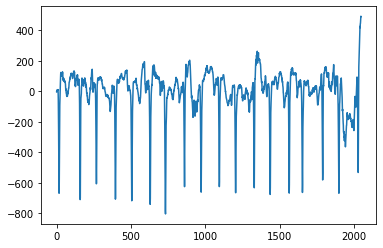

In [422]:
i = random.randint(0,len(self)-1)
x = self[i]["x"]
plt.plot(x)

In [ ]:
def get_batch_ssl(loader_labeled,loader_unlabeled):
    # Set up all stuff
    counter_labeled,counter_unlabeled =                    0,                      0
    length_labeled,length_unlabeled   =  len(loader_labeled),  len(loader_unlabeled)
    iter_labeled,    iter_unlabeled   = iter(loader_labeled), iter(loader_unlabeled)
    maxlen                            =  max(length_labeled,       length_unlabeled)
    
    # Get examples
    for _ in range(maxlen):
        if counter_labeled   == length_labeled:
            iter_labeled   = iter(loader_labeled)
        if counter_unlabeled == length_unlabeled:
            iter_unlabeled = iter(loader_unlabeled)
        counter_labeled   += 1
        counter_unlabeled += 1

        # Return next element in iterator
        yield (next(iter_labeled), next(iter_unlabeled))

def do_epoch_ssl(model: torch.nn.Module, state: dict, config: dict, 
                 dataloader_labeled:   torch.utils.data.DataLoader, 
                 dataloader_unlabeled: torch.utils.data.DataLoader, 
                 criterion: Callable, 
                 criterion_crossentropy: Callable) -> list:
    """
    Minimum do_epoch example
    1. Select device to send tensors
    2. Initialize loss function
    3. Predict + optimize batch
    4. Save loss per batch (useful given size of dataset)
    """
    
    # Record progress
    max_length = max(len(dataloader_labeled),len(dataloader_unlabeled))
    batch_loss = np.zeros((max_length,),dtype='float16')

    # Create transforms
    if ('data_pre' in config):
        data_pre     = sak.from_dict(config["data_pre"])
    if ('augmentation' in config) and model.training:
        augmentation = sak.from_dict(config["augmentation"])
    if ('data_post' in config):
        data_post    = sak.from_dict(config["data_post"])

    # Select iterator decorator
    train_type = 'Train' if model.training else 'Valid'
    iterator = sak.get_tqdm(dataloader, config.get('iterator',''), 
                            desc="({}) Epoch {:>3d}/{:>3d}, Loss {:0.3f}".format(train_type, 
                                                                                 state['epoch']+1, 
                                                                                 config['epochs'], np.inf))

    # Iterate over all data in train/validation/test dataloader:
    print_loss = np.inf
    for i, inputs in enumerate(iterator):
        # Apply data transforms
        if ('data_pre' in config):
            data_pre(inputs=inputs)
        if ('augmentation' in config) and model.training:
            augmentation(inputs=inputs)
        if ('data_post' in config):
            data_post(inputs=inputs)

        # Map all inputs to device
        for k in inputs:
            inputs[k] = inputs[k].to(state['device'], non_blocking=True)

        # Set gradient to zero
        if model.training: 
            state['optimizer'].zero_grad()

        # Predict input data
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(inputs=inputs,outputs=outputs,state=state)

        # Break early
        if torch.isnan(loss):
            raise ValueError("Nan loss value encountered. Stopping...")

        # Retrieve for printing purposes
        print_loss = loss.item()
        
        # Optimize network's weights
        if model.training:
            loss.backward()
            state['optimizer'].step()

        # Accumulate losses
        batch_loss[i] = print_loss

        # Change iterator description
        if isinstance(iterator,tqdm.tqdm):
            if i == len(iterator)-1:
                iterator.set_description("({}) Epoch {:>3d}/{:>3d}, Loss {:10.3f}".format(train_type, state['epoch']+1, config['epochs'], np.mean(batch_loss)))
            else:
                iterator.set_description("({}) Epoch {:>3d}/{:>3d}, Loss {:10.3f}".format(train_type, state['epoch']+1, config['epochs'], print_loss))
            iterator.refresh()

    return batch_loss


def train_model_ssl(model, state: dict, config: dict, loader: torch.utils.data.DataLoader):
    # Send model to device
    model = model.to(state['device'])

    # Instantiate criterion
    criterion = sak.from_dict(config['loss'])
    
    # Initialize best loss for early stopping
    if 'best_loss' not in state:
        state['best_loss'] = np.inf

    # Get savedir string
    if "savedir" in config:          str_savedir = 'savedir'
    elif "save_directory" in config: str_savedir = 'save_directory'
    else: raise ValueError("Configuration file should include either the 'savedir' or 'save_directory' fields [case-sensitive]")

    # Iterate over epochs
    for epoch in range(state['epoch'], config['epochs']):
        try:
            # Store current epoch
            state['epoch'] = epoch
            
            # Train model
            loss_train = do_epoch(model.train(), state, config, loader, criterion)
            state['loss_train'] = np.mean(loss_train)

            # Save model/state info
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'checkpoint.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'checkpoint.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'checkpoint.state'), mode='wb')
            model = model.to(state['device'])
            
            # Log train loss
            with open(os.path.join(config[str_savedir],'log.csv'),'a') as f:
                csvwriter = csv.writer(f)
                csvwriter.writerow(["(Train) Epoch {:>3d}/{:>3d}, Loss {:10.3f}, Time {}".format(state['epoch']+1, config['epochs'], state['loss_train'], time.ctime())])

            # Check if loss is best loss
            if state['loss_train'] < state['best_loss']:
                state['best_loss'] = state['loss_train']
                state['best_epoch'] = epoch
                
                # Copy checkpoint and mark as best
                shutil.copyfile(os.path.join(config[str_savedir],'checkpoint.model'), os.path.join(config[str_savedir],'model_best.model'))
                shutil.copyfile(os.path.join(config[str_savedir],'checkpoint.state'), os.path.join(config[str_savedir],'model_best.state'))
        except KeyboardInterrupt:
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'keyboard_interrupt.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'keyboard_interrupt.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'keyboard_interrupt.state'), mode='wb')
            raise
        except:
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'error.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'error.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'error.state'), mode='wb')
            raise


def train_valid_model_ssl(model, state: dict, config: dict, 
                          loader_train: torch.utils.data.DataLoader, 
                          loader_valid: torch.utils.data.DataLoader):
    # Send model to device
    model = model.to(state['device'])

    # Instantiate criterion
    criterion = sak.from_dict(config['loss'])
    
    # Initialize best loss for early stopping
    if 'best_loss' not in state:
        state['best_loss'] = np.inf

    # Get savedir string
    if "savedir" in config:          str_savedir = 'savedir'
    elif "save_directory" in config: str_savedir = 'save_directory'
    else: raise ValueError("Configuration file should include either the 'savedir' or 'save_directory' fields [case-sensitive]")

    # Iterate over epochs
    for epoch in range(state['epoch'], config['epochs']):
        try:
            # Store current epoch
            state['epoch'] = epoch
            
            # Training model
            loss_train = do_epoch(model.train(), state, config, loader_train, criterion)
            state['loss_train'] = np.mean(loss_train)

            # Validate results
            with torch.no_grad():
                loss_valid = do_epoch(model.eval(), state, config, loader_valid, criterion)
            state['loss_validation'] = np.mean(loss_valid)

            # Update learning rate scheduler
            if 'scheduler' in state:
                state['scheduler'].step(state['loss_validation'])

            # Save model/state info
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'checkpoint.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'checkpoint.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'checkpoint.state'), mode='wb')
            model = model.to(state['device'])
            
            # Log train/valid losses
            with open(os.path.join(config[str_savedir],'log.csv'),'a') as f:
                csvwriter = csv.writer(f)
                csvwriter.writerow(["(Train) Epoch {:>3d}/{:>3d}, Loss {:10.3f}, Time {}".format(state['epoch']+1, config['epochs'], state['loss_train'], time.ctime())])
                csvwriter.writerow(["(Valid) Epoch {:>3d}/{:>3d}, Loss {:10.3f}, Time {}".format(state['epoch']+1, config['epochs'], state['loss_validation'], time.ctime())])

            # Check if loss is best loss
            compound_loss = 2*state['loss_train']*state['loss_validation']/(state['loss_train']+state['loss_validation'])
            if compound_loss < state['best_loss']:
                state['best_loss'] = compound_loss
                state['best_epoch'] = epoch
                
                # Copy checkpoint and mark as best
                shutil.copyfile(os.path.join(config[str_savedir],'checkpoint.model'), os.path.join(config[str_savedir],'model_best.model'))
                shutil.copyfile(os.path.join(config[str_savedir],'checkpoint.state'), os.path.join(config[str_savedir],'model_best.state'))
            
        except KeyboardInterrupt:
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'keyboard_interrupt.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'keyboard_interrupt.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'keyboard_interrupt.state'), mode='wb')
            raise
        except:
            model = model.cpu().eval()
            torch.save(model,              os.path.join(config[str_savedir],'error.model'),      pickle_module=dill)
            torch.save(model.state_dict(), os.path.join(config[str_savedir],'error.state_dict'), pickle_module=dill)
            sak.pickledump(state, os.path.join(config[str_savedir],'error.state'), mode='wb')
            raise


# I/O FILES

    aaa = pd.DataFrame(np.random.rand(10000,10000))
    
    ~~~ FEATHER ~~~
    767M	test.fth
    299 ms ± 21 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

    ~~~ HDF5 ~~~
    764M	test.hdf5
    451 ms ± 92.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

    ~~~ CSV ~~~
    1,8G	test.csv
    29 s ± 291 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

    ~~~ WFDN ~~~
    382M	test.dat
    732K	test.hea
    3.96 s ± 198 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)

    ~~~ FLEET ~~~
    771M	test.fleet # With pyarrow
    765M	test.fleet # With pickle protocol 5
    # 315 ms ± 10.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each) # With pyarrow
    161 ms ± 446 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)  # With pickle protocol 5

    https://towardsdatascience.com/what-format-should-i-store-my-ecg-data-in-for-dl-training-bc808eb64981

In [49]:
import pickle
import fleetfmt
import pathlib
import numpy as np
import random
import skimage
import skimage.util

aaa = np.random.rand(10000,10000)
print("Writing numpy content to a new Fleet file.")
with pathlib.Path("test.fleet").open('wb') as fhandle, fleetfmt.FileWriter(fhandle) as writer:
    for i,value in enumerate(aaa):
        writer.append(f"jakhgkjahgkjhak {i}", value)
print("Done.")
!du -sh test.fleet

Writing numpy content to a new Fleet file.
Done.
766M	test.fleet


In [50]:
%%timeit
with pathlib.Path("test.fleet").open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
    # get keys
    dkeys = list(reader.keys())

    # get values
    for key in dkeys:
        value = reader.read(key)


162 ms ± 381 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [52]:
with pathlib.Path("test.fleet").open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
    # get keys
    dkeys = list(reader.keys())

    # get random value
    %timeit key = random.choice(dkeys)
    %timeit key = random.choice(dkeys); reader.read(key)


279 ns ± 1.02 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
18.4 µs ± 27.2 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


# TEST I/O FORMAT

In [11]:
import ishneholterlib
import struct

window = 2048
max_size = window*10
window_step = max_size-window//4
target_fs = 250
target_dtype = "float32"

print("Writing numpy content to a new Fleet file.")
with pathlib.Path(f"/media/guille/DADES/DADES/ECG/unsupervised_{target_dtype}.fleet").open('wb') as fhandle, fleetfmt.FileWriter(fhandle) as writer:
    print("MUSE dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/ECGData/*.csv")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            tmp = pd.read_csv(file)
            tmp = tmp.round(3)
            tmp.columns = map(lambda x: str(x).upper(), tmp.columns)
            fs = 500
            hea = list(tmp.columns)
            tmp = sak.signal.interpolate.interp1d(tmp.values,target_fs*tmp.shape[0]//fs,axis=0).T
            for k,value in zip(hea,tmp): 
                if value.size < window: continue
                writer.append(f"MUSE/{fname[5:]}/{k}###0", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("Brugada dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/Brugada/Databases/HUVR/*.ecg")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg = ishneholterlib.Holter(file)
            ecg.load_data()
            fs = ecg.sr
            for lead in ecg.lead:
                k = lead.spec_str().upper()
                data = lead.data.copy()
                data = sak.signal.interpolate.interp1d(data,target_fs*data.size//fs)
                if data.size > max_size:
                    data = skimage.util.view_as_windows(data,(max_size,),step=window_step)
                else:
                    data = data[None,]
                for i,value in enumerate(data):
                    if i == 0:
                        continue
                    if value.size < window: continue
                    writer.append(f"Brugada/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("Fallot dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/Fallot/ECGs/*.csv")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            tmp = pd.read_csv(file)
            tmp = tmp.round(3)
            tmp.columns = map(lambda x: str(x).upper(), tmp.columns)
            hea = map(lambda x: str(x).upper(), tmp.columns)
            fs = 1/np.unique(np.round(np.diff(tmp["TIME IN SEC."].values),5))
            assert fs.size == 1, "check fs!!!"
            fs = int(fs[0])
            hea = list(tmp.columns)
            tmp = sak.signal.interpolate.interp1d(tmp.values,target_fs*tmp.shape[0]//fs,axis=0).T
            for k,value in zip(hea,tmp): 
                if k == "TIME IN SEC.": continue
                if value.size < window: continue
                writer.append(f"Fallot/{fname}/{k}###0", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("HCM dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/HCMData/CSV/*.csv")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            tmp = pd.read_csv(file,header=None)[:-500]/1000
            tmp.columns = map(lambda x: str(x).upper(), StandardHeader)
            fs = 500
            tmp = sak.signal.interpolate.interp1d(tmp.values,target_fs*tmp.shape[0]//fs,axis=0).T
            for k,value in zip(StandardHeader,tmp): 
                if value.size < window: continue
                writer.append(f"HCM/{fname}/{k}###0", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("Challenge dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/Challenge/*.mat")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            sig,hea = wfdb.rdsamp(os.path.join(root,fname),return_res=16)
            hea["sig_name"] = list(map(lambda x: str(x).upper(), hea["sig_name"]))
            fs = hea["fs"]
            sig = sak.signal.interpolate.interp1d(sig,target_fs*sig.shape[0]//fs,axis=0).T
            for k,lead in zip(hea["sig_name"],sig):
                if lead.size > max_size:
                    data = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    data = lead[None,]
                for i,value in enumerate(data):
                    if value.size < window: continue
                    writer.append(f"Challenge/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("LongQT dataset")
    time.sleep(0.5)
    import xml.etree.ElementTree as ET
    ET.register_namespace("","http://www3.medical.philips.com")
    all_files = (glob.glob("/home/guille/DADES/DADES/ECG/LONG_QT/LongQT_*/*.XML") + 
                 glob.glob("/home/guille/DADES/DADES/ECG/LONG_QT/LongQT_*/*/*.XML"))
    head = "{http://www3.medical.philips.com}"
    namespace = {"xmlns:ns0": "http://www3.medical.philips.com",
                 "xmlns:xsi": "http://www.w3.org/2001/XMLSchema-instance",
                 "xsi:schemaLocation": "http://www3.medical.philips.com PhilipsECG.xsd"}
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            tree = ET.parse(file)
            if len(tree.findall("FullDisclosure")) != 0:
                continue
            fs = float(tree.findall("StripData/SampleRate")[0].text)
            ecg = {}
            for lead in tree.findall("StripData/WaveformData"):
                ecg[lead.get("lead").upper()] = np.array(lead.text.strip().split(","),dtype=int)
            ecg = np.array([ecg[k] for k in StandardHeader])
            ecg = sak.signal.interpolate.interp1d(ecg,round(ecg.shape[1]*250/fs))
            for k,lead in zip(StandardHeader,ecg):
                if lead.size > max_size:
                    data = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    data = lead[None,]
                for i,value in enumerate(data):
                    if value.size < window: continue
                    writer.append(f"LongQT/{fname}/{k}###{i}", (value/1000).astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("THEW dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/THEWProject/*/*.ecg")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            rt,stu_id = os.path.split(root)
            ecg = ishneholterlib.Holter(file,check_valid=False)
            ecg.load_data()
            fs = ecg.sr
            for lead in ecg.lead:
                k = lead.spec_str().upper()
                data = lead.data.copy()
                data = sak.signal.interpolate.interp1d(data,target_fs*data.size//fs)
                if data.size > max_size:
                    data = skimage.util.view_as_windows(data,(max_size,),step=window_step)
                else:
                    data = data[None,]
                for i,value in enumerate(data):
                    if value.size < window: continue
                    if np.all(np.abs(np.diff(value)) < 1e-6): continue
                    writer.append(f"THEW/{stu_id}_{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("DeepFake dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/DeepFake/*.asc")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg = pd.read_csv(file,header=None,sep=" ")
            fs = 500
            ecg = sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs)
            for k,value in zip(StandardHeader,ecg):
                k = k.upper()
                if value.size < window: continue
                writer.append(f"DeepFake/{fname}/{k}###0", (value/1000).astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("SoO dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/Delineator/SoO/RETAG/*.txt")
    db = pd.read_csv('/home/guille/DADES/DADES/ECG/Delineator/SoO/DATABASE_MANUAL.csv')
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg = pd.read_csv(file,header=0,sep=",",index_col=0)
            hea = list(map(lambda x: str(x).upper(), ecg.columns))
            filt_id = (db["ID"] == int(fname.split("-")[0]))
            fs = db[filt_id]["Sampling_Freq"].values[0]
            ecg = np.round(sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs))/(2**15)
            for k,lead in zip(hea,ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"SoO/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("EDB dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/PhysioNet/EDB/*.dat")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg,hea = wfdb.rdsamp(file[:-4])
            fs = hea["fs"]
            ecg = sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs)
            for k,lead in zip(hea["sig_name"],ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"EDB/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("SVDB dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/PhysioNet/SVDB/*.dat")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            ecg,hea = wfdb.rdsamp(file[:-4])
            fs = hea["fs"]
            ecg = sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs)
            for k,lead in zip(hea["sig_name"],ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"SVDB/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("PredictAF dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/PredictAF/*/*/*.NHS")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            rt,pat_id = os.path.split(root)
            rt,stu_id = os.path.split(rt)
            ecg,fs = src.reader.readNHS(file)
            ecg = sak.signal.interpolate.interp1d(ecg.T,int(target_fs*ecg.shape[0]//fs)).T
            for k,lead in zip(StandardHeader,ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if i < 5:
                        continue
                    if value.size < window: continue
                    writer.append(f"PredictAF/{stu_id}_{pat_id}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("Zhejiang dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/ECG/RubenDoste/ZhejiangDatabase/PVCVTRawECGData/*.csv")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            if fname in ["onsets","offsets"]: continue
            ecg = pd.read_csv(file,header=0)
            hea = list(ecg.columns)
            fs = 2000
            ecg = np.round(sak.signal.interpolate.interp1d(ecg.T,target_fs*ecg.shape[0]//fs))/(2**13)
            for k,lead in zip(hea,ecg):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"Zhejiang/{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

    print("HUVR_CARTO dataset")
    time.sleep(0.5)
    all_files = glob.glob("/home/guille/DADES/DADES/EGMDelineator/Databases/CARTOEXPORT/*/*ECG_Export.txt")
    for file in tqdm.tqdm(all_files):
        try:
            root,fname,ext = sak.splitrfe(file)
            rt,pat_id = os.path.split(root)
            fs = 2000
            signal,header = src.reader.Read_CARTO3_ECG(file)
            channels = np.array(sak.map_upper([c.split("(")[0].replace(" ","") for c in header["Channels"]]))
            idx_header = np.array([np.where(channels == c)[0][0] for c in StandardHeader])
            signal = np.round(sak.signal.interpolate.interp1d(signal[idx_header],target_fs*signal.shape[1]//fs))/(2**10)
            for k,lead in zip(StandardHeader,signal):
                k = k.upper()
                if lead.size > max_size:
                    lead = skimage.util.view_as_windows(lead,(max_size,),step=window_step)
                else:
                    lead = lead[None,]
                for i,value in enumerate(lead):
                    if value.size < window: continue
                    writer.append(f"HUVR_CARTO/{pat_id}_{fname}/{k}###{i}", value.astype(target_dtype))
        except KeyboardInterrupt:
            raise
        except:
            continue

time.sleep(0.5)
print("Done.")
time.sleep(0.5)
!du -sh /media/guille/DADES/DADES/ECG/unsupervised.fleet

Writing numpy content to a new Fleet file.
MUSE dataset


100%|██████████| 10646/10646 [01:45<00:00, 100.69it/s]


Brugada dataset


100%|██████████| 7/7 [01:24<00:00, 12.06s/it]


Fallot dataset


100%|██████████| 1941/1941 [00:17<00:00, 112.98it/s]


HCM dataset


100%|██████████| 153/153 [00:00<00:00, 171.67it/s]


Challenge dataset


100%|██████████| 41704/41704 [05:48<00:00, 119.61it/s]


LongQT dataset


100%|██████████| 807/807 [00:07<00:00, 109.33it/s]


THEW dataset


100%|██████████| 1700/1700 [2:58:24<00:00,  6.30s/it]  


DeepFake dataset


100%|██████████| 150000/150000 [12:54<00:00, 193.75it/s]


SoO dataset


100%|██████████| 541/541 [00:30<00:00, 17.77it/s]


EDB dataset


100%|██████████| 90/90 [00:27<00:00,  3.26it/s]


SVDB dataset


100%|██████████| 78/78 [00:05<00:00, 15.08it/s]


PredictAF dataset


100%|██████████| 235/235 [06:30<00:00,  1.66s/it]


Zhejiang dataset


100%|██████████| 336/336 [00:08<00:00, 39.79it/s]


HUVR_CARTO dataset


100%|██████████| 20618/20618 [37:29<00:00,  9.17it/s] 


Done.
116G	/media/guille/DADES/DADES/ECG/unsupervised.fleet


In [15]:
with pathlib.Path("/media/guille/DADES/DADES/ECG/unsupervised_16.fleet").open('rb') as fhandle, fleetfmt.FileReader(fhandle) as reader:
    # get keys
    dkeys = list(reader.keys())

    # get random value
    %timeit key = random.choice(dkeys)
    %timeit key = random.choice(dkeys); reader.read(key)


422 ns ± 0.346 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)
1.64 ms ± 32 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [35]:
all_keys = {}
for key in dkeys:
    DB = key.split("/")[0]
    
    if DB not in all_keys:
        all_keys[DB] = 0
        
    all_keys[DB] += 1
all_keys

{'MUSE': 127752,
 'Brugada': 92364,
 'Fallot': 23292,
 'HCM': 1836,
 'Challenge': 519984,
 'LongQT': 9624,
 'THEW': 2194152,
 'DeepFake': 1200000,
 'SoO': 6492,
 'EDB': 16560,
 'SVDB': 3588,
 'PredictAF': 210738,
 'Zhejiang': 4008,
 'HUVR_CARTO': 247416}